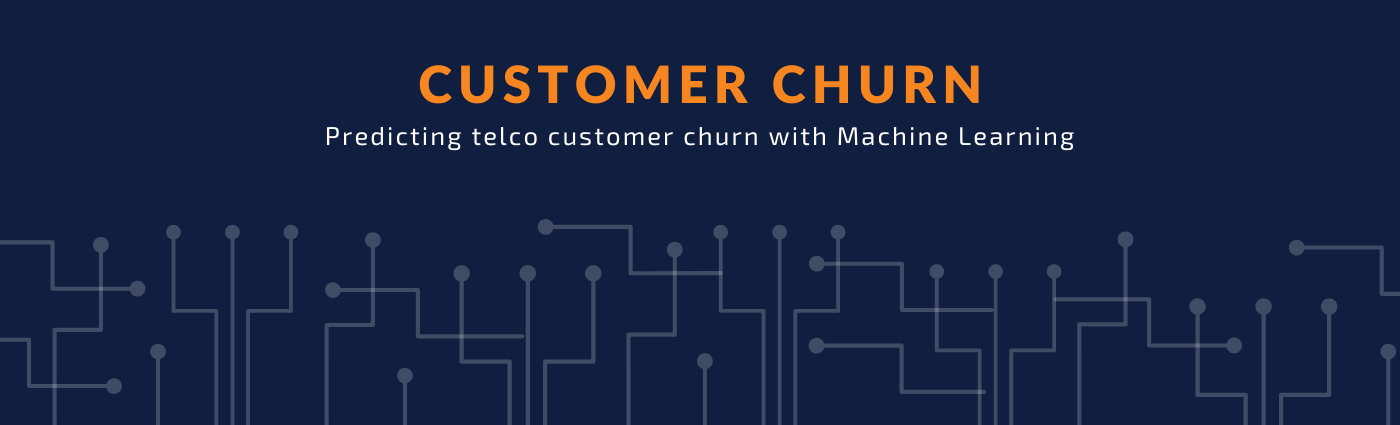

## In this project we will try to best predict the possibility of customers churning (that means quitting the service) from a telco (telecommunications) company from a dataframe composed of 7000 customers obtained from www.kaggle.com. First we will clean the database if necessary, visualize the variables for a better understanding, try different machine learning models, tune parameters for the one with the best accuracy score, and analyze the feature importances.

In [ ]:
#importing necessary packages
import warnings
warnings.filterwarnings("ignore")

#algebra, database managing and visualization packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.colors import ListedColormap

#Machine Learning packages
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import eli5

#File direction
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Reading the file and setting a work copy. Then we will take a peek at the data.

In [ ]:
df_original = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = df_original.copy()

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

# Cleaning Data

The dataset is pretty clean already, I only notice some empty values in "TotalCharges", so I'll drop them to transform the column to a "float" type.

In [ ]:
df.drop(df.loc[df['TotalCharges'] == " "].index, inplace=True)
df.TotalCharges = df.TotalCharges.astype(float)

# Visualization

## Target Variable

In [ ]:
fig = plt.figure(figsize=(7,7))
df.Churn.value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, shadow=True, explode=(0,0.05), colors = ["mediumaquamarine", "darksalmon"])
plt.title("Customers Churn Proportion",fontdict = {'fontsize' : 20})
churners = df.Churn.value_counts()[1]
non_c = df.Churn.value_counts()[0]
print(f"Absolute Value of Churners: {churners}") 
print(f"Abbsolute Values of Non-Churners: {non_c}")

## Numerical Variables

In [ ]:
numerical = ["MonthlyCharges", "TotalCharges", "tenure"]
df[numerical].hist(layout=(1,3),figsize=(20,7), color= "steelblue", grid=False)
plt.suptitle("Numerical Variables Distribution", fontsize=20)

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(df[numerical].corr(),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), annot=True)
plt.title("Numerical Variables Correlation Matrix", fontsize="20")

- Its pretty clear that TotalCharges would be correlated to the other two variables, being that is the monthly charges multiplied by the months a customer has been a client

## Numerical Variables in respect to Churners

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
for variable, subplot in zip(numerical, ax.flatten()):
    sns.boxplot(x=df["Churn"], y=df[variable], ax=subplot, palette = "Set2").set_title(str(variable))

- The Monthly plan doesn't seem to be such a big driver of churn, but we can see that 75% of churners pay between 60 and 100 dollars a month
- One important mark we can see in this plots that 50% of Churners leave the company before the first year goes by.

## Categorical Variables

In [ ]:
categorical = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling"]
fig, ax = plt.subplots(3, 5, figsize=(20, 12))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot, palette = "Set2")


plt.figure(figsize=(3,3))
chart = sns.countplot(df.PaymentMethod, palette = "Set2")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

## Categorical values in respect to Churners

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))
for variable, subplot in zip(categorical, ax.flatten()):
    result = pd.crosstab(df['Churn'], df[variable])
    result_pct = result.div(result.sum(1), axis=0)
    ax = result_pct.plot(kind='bar', stacked=True, ax=subplot, color = ["mediumaquamarine", "coral", "mediumslateblue"])
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3, fancybox=True, shadow=True)
        ax.set_title(str(variable), y=-0.10)
plt.figure(figsize=(3,3))
result = pd.crosstab(df['Churn'], df["PaymentMethod"])
result_pct = result.div(result.sum(1), axis=0)
ax1 = result_pct.plot(kind='bar', stacked=True, color = ["mediumaquamarine", "coral", "mediumslateblue", "orchid"])

for p in ax1.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax1.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center')
ax1.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Payment Method")
plt.show()

### We can see some quick interesting points here, but we got to be careful to remind that we're seeing proportional values. So we also have to take into account the absolute values afterwards

- The churners are relative bigger users of Fiber Optic as Internet Service. Could this be a reason of changing service?
- Churners  use less complementary services (such as Online Security, Online BackUp, Device Protection, etc) in comparison to non-Churners.
- It seems that having a Month-to-Month contract and Paperless Billing could be some predictors of Churn.

## Machine Learning
### *To churn or not to churn, that is the question*
### Predicting binary classification

In [ ]:
#Setting the target variable and features
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)

#Setting the preprocessor for the numerical variables (Scaling) and categorical variables (One Hot Encoding)
preprocessor = ColumnTransformer(transformers=[("num",StandardScaler(),numerical),("cat", OneHotEncoder(drop="if_binary"), categorical)])

#Calling the different classifiers to try
classifiers = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

#Setting the Cross-Validation method
cv = KFold(n_splits=4, shuffle=True, random_state=42)

#"For" loop to test every classifier and get the Mean Score of each one
for name, classifier in classifiers:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', classifier)])
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)
    mean_score = round(np.mean(cv_scores), 4)
    print(f"{name} cross validation accuarcy score: {mean_score}")

In [ ]:
#Now that we know Logistic Regression is the best one, we will try to fine tune it with Search Grid
logistic = LogisticRegression(random_state=42)
pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', logistic)])

#Parameters to try out
param_grid = [
  {'model__penalty': ['l1'], 'model__solver': [ 'liblinear', 'saga'], "model__C": np.logspace(-4, 4, 50)},
  {'model__penalty': ['l2'], 'model__solver': ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga'], "model__C": np.logspace(-4, 4, 50)},
 ]

clf = GridSearchCV(pipe, param_grid)
clf.fit(X, y)

#Getting the best parameters
print('Best Params:', clf.best_estimator_.get_params()['model'])

#Getting the scores, mean score and Standard Deviation of a 4 Cross Validation test
CV_Result = cross_val_score(clf, X, y, cv=4, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

In [ ]:
#We fit the enhanced model with the parameters we got from the Grid Search
e_model = LogisticRegression(penalty ="l1" , C =0.18420699693267145 , solver ='saga' , random_state=42)
e_clf = Pipeline(steps=[('preprocessor', preprocessor),('model', e_model)])
e_clf.fit(X,y)

#We get the names of the columns converted with OneHot Encoder from the Transformer of the Pipeline
onehot_columns = list(e_clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(input_features=categorical))

#We add the names to the numerical columns
features_list = numerical + onehot_columns

#We get the weights from model with the features list as names and print the dataframe
features_df = eli5.formatters.as_dataframe.explain_weights_df(
    e_clf.named_steps['model'],
    feature_names=features_list)
features_df.head(10)

In [ ]:
#Plotting the faeture weights in a horizontal bar plot
features_df.head(10).plot.barh(x="feature", y="weight", figsize=(10,7))
plt.title("10 Most Important Features", fontsize=20)

### * We can see that, in fact, the most important feature to predict Churn behavior is having the Fiber Optic. This might be telling us about a low quality of service in this regard.

### * Having a contract from month-to-month also appears to influence the tendecy to churn. So an strategy to try to change this contracts into long-terms would be a good advice.

### * Total charges are much lower in Churners than non-Churners because it's just the Monthly Charges * Months of Tenure, I don't really see it as a good predictor. We can try to fit a model without it and see how it goes.


In [ ]:
#We drop the "TotalCharges" column from the features variables and numerical variables because we use this list in the pipeline
X = df.drop("TotalCharges", axis=1)
numerical.remove("TotalCharges")

CV_Result = cross_val_score(e_clf, X, y, cv=4, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

In [ ]:
#We fit the new model and repeat the process
e_clf.fit(X,y)
onehot_columns = list(e_clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(input_features=categorical))

features_list = numerical + onehot_columns 
features_df = eli5.formatters.as_dataframe.explain_weights_df(
    e_clf.named_steps['model'],
    feature_names=features_list)

features_df.head(10).plot.barh(x="feature", y="weight", figsize=(10,7))
plt.title("10 Most Important Features", fontsize=20)

### Without TotalCharges we have virtually the same prediction score. The model compensates by giving more weight to the Fiber Optic feature, the others remains quite the same.